# Stability of the RPN-signature to the regions-of-interest

In [7]:
# import neccessary modules and load all data
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns; sns.set()
sns.set(style="ticks")
import warnings
warnings.filterwarnings('ignore')
from mlxtend.evaluate import permutation_test
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.externals import joblib
from tqdm import tqdm
import statsmodels.api as sm

# Load all data:
study1 = pd.read_csv("../res/bochum_sample_excl.csv")[["HPT", "CPT", "MPT_log_geom",
                                                       "mean_QST_pain_sensitivity", "prediction"]]
study2 = pd.read_csv("../res/essen_sample_excl.csv")[["HPT", "CPT", "MPT_log_geom",
                                                      "mean_QST_pain_sensitivity", "prediction"]]
study3 = pd.read_csv("../res/szeged_sample_excl.csv")[["HPT", "CPT", "MPT_log_geom",
                                                       "mean_QST_pain_sensitivity", "prediction"]]
# merge datasets
study1["study"]="Study 1"
study2["study"]="Study 2"
study3["study"]="Study 3"
df = pd.concat([study1, study2, study3])
#df = df.dropna()

# load the trained RPN-model
rpn = joblib.load("../res/predictive_model.sav")

# load features for each study
X_bochum = joblib.load("../res/feature_bochum.sav")
X_essen = joblib.load("../res/feature_essen.sav")
X_szeged = joblib.load("../res/feature_szeged.sav")

X=np.concatenate((X_bochum, X_essen, X_szeged))

## Step 1. Stability to region drop-out

On real data, such drop-out can be caused e.g. by signal drop-out due to susceptibility artifact (typically in medial frontal regions).
We simulate drop out be zeroing out N regions randomly and plot the histogram of correlations of the RPN-scores computed with random drop-out (drop-out score) with the measured composite pain sensitivity.

In [62]:
def drop_out_region(num_drop_out=0):
    #load atlas labels
    labels = pd.read_csv("../data/atlas_relabeled.tsv", sep="\t")[["index", "labels", "modules"]]
    labels.loc[-1] = [0, "aMEAN_GM", "aMEAN_GM"]  # adding a row
    labels.index = labels.index + 1  # shifting index
    labels = labels.sort_index()  # sorting by index

    # get coefficients of the RPN
    RES = np.zeros(len(labels)*(len(labels)-1)/2)
    featuremask = rpn.named_steps['fsel'].get_support()
    RES[featuremask] = rpn.named_steps['model'].coef_
    
    # zero-out some regions by randomly selecting from those having a nonzero coef
    indices=np.random.choice(np.nonzero(RES)[0], num_drop_out, replace=False)
    X_drop=X.copy()
    X_drop[:, indices]=0
    
    predicted = rpn.predict(X_drop)
    return(predicted)

In [83]:
numiter=50
max_drop_N=22
num_dropped=np.zeros(max_drop_N*numiter)
correlation=np.zeros(max_drop_N*numiter)

np.random.seed(0)
idx=0
for dropN in tqdm(range(max_drop_N)):
    for iter in range(numiter):
        
        correlation[idx] = np.corrcoef(df['mean_QST_pain_sensitivity'], drop_out_region(dropN))[0,1]
        num_dropped[idx]=dropN
        idx=idx+1

data=pd.DataFrame({
    'num_dropped' : num_dropped,
    'correlation' : correlation
})





  0%|          | 0/22 [00:00<?, ?it/s]

  5%|▍         | 1/22 [00:02<01:01,  2.91s/it]

  9%|▉         | 2/22 [00:05<00:58,  2.91s/it]

 14%|█▎        | 3/22 [00:08<00:55,  2.93s/it]

 18%|█▊        | 4/22 [00:11<00:53,  2.95s/it]

 23%|██▎       | 5/22 [00:14<00:50,  2.95s/it]

 27%|██▋       | 6/22 [00:17<00:47,  2.95s/it]

 32%|███▏      | 7/22 [00:20<00:44,  2.96s/it]

 36%|███▋      | 8/22 [00:23<00:41,  2.96s/it]

 41%|████      | 9/22 [00:26<00:38,  2.96s/it]

 45%|████▌     | 10/22 [00:29<00:35,  2.96s/it]

 50%|█████     | 11/22 [00:32<00:32,  2.95s/it]

 55%|█████▍    | 12/22 [00:35<00:29,  2.95s/it]

 59%|█████▉    | 13/22 [00:38<00:26,  2.95s/it]

 64%|██████▎   | 14/22 [00:41<00:23,  2.95s/it]

 68%|██████▊   | 15/22 [00:44<00:20,  2.95s/it]

 73%|███████▎  | 16/22 [00:47<00:17,  2.95s/it]

 77%|███████▋  | 17/22 [00:50<00:14,  2.95s/it]

 82%|████████▏ | 18/22 [00:53<00:11,  2.95s/it]

 86%|████████▋ | 19/22 [00:55<00:08,  2.95s/it]

 91%|█████████ | 20/22 [00:58<00:05,

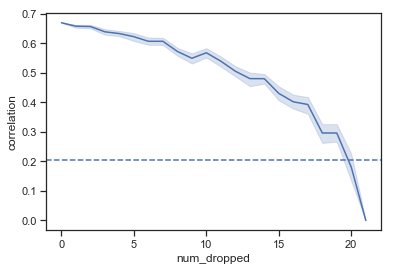

In [84]:
# plot drop-out effect
ax=sns.lineplot(x="num_dropped", y="correlation", ci=95, data=data)
ax.axhline(0.2061, ls='--')
plt.show()

### *Figure SE2.1. The tolerance of the RPN-signature to region drop-out.*
*The mean (and 95% confidence intervals) correlation between predicted and observed pain sensitivity is plotted as a function of the number of regions dropped out randomly by setting their timecourse to constant zero. Dashed line denotes R=0.206, i.e. the correlation value belonging to the p=0.05 significance threshold. The analysis revealed a considerable robustness to drop-out; the average prediction accuracy remained significant by the random drop-out of up to 19 regions out of 21, although – as expected - prediction accuracy constantly decreased with an increasing number of dropped regions.*


## Step 2. Stability to the definition region-boundaries (mixed signal)

In [72]:
def mix_region(mixing_weight=0):
    X_noisy=X.copy()
    X_noisy = X_noisy + mixing_weight * np.random.normal(np.random.normal(0, 1, X_noisy.shape))
    predicted = rpn.predict(X_noisy)
    return(predicted)

In [85]:
numiter=50
weights=np.linspace(start=0, stop=0.15, num=10)
noise_weight=np.zeros(len(weights)*numiter)
correlation=np.zeros(len(weights)*numiter)

np.random.seed(0)
idx=0
for w in tqdm(weights):
    for iter in range(numiter):  
        correlation[idx] = np.corrcoef(df['mean_QST_pain_sensitivity'], mix_region(w))[0,1]
        noise_weight[idx] = w
        idx=idx+1

data=pd.DataFrame({
    'noise_weight' : noise_weight,
    'correlation' : correlation
})



  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:03<00:31,  3.56s/it]

 20%|██        | 2/10 [00:06<00:25,  3.20s/it]

 30%|███       | 3/10 [00:09<00:21,  3.09s/it]

 40%|████      | 4/10 [00:12<00:18,  3.07s/it]

 50%|█████     | 5/10 [00:15<00:15,  3.08s/it]

 60%|██████    | 6/10 [00:18<00:12,  3.06s/it]

 70%|███████   | 7/10 [00:21<00:09,  3.04s/it]

 80%|████████  | 8/10 [00:24<00:06,  3.04s/it]

 90%|█████████ | 9/10 [00:27<00:03,  3.03s/it]

100%|██████████| 10/10 [00:30<00:00,  3.05s/it]



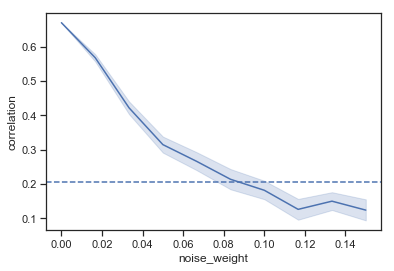

In [86]:
# plot drop-out effect
ax=sns.lineplot(x="noise_weight", y="correlation", ci=95, data=data)
ax.axhline(0.2061, ls='--')

plt.show()

### *Figure SE2.2. The tolerance of the RPN-signature to noise added to the regional timecourses.*
*The mean correlation (and 95% confidence intervals) between predicted and observed pain sensitivity is plotted as a function of the amount of noise added to all timecourses, simultaneously. Dashed line denotes R=0.206, i.e. the correlation value belonging to the p=0.05 significance threshold. *